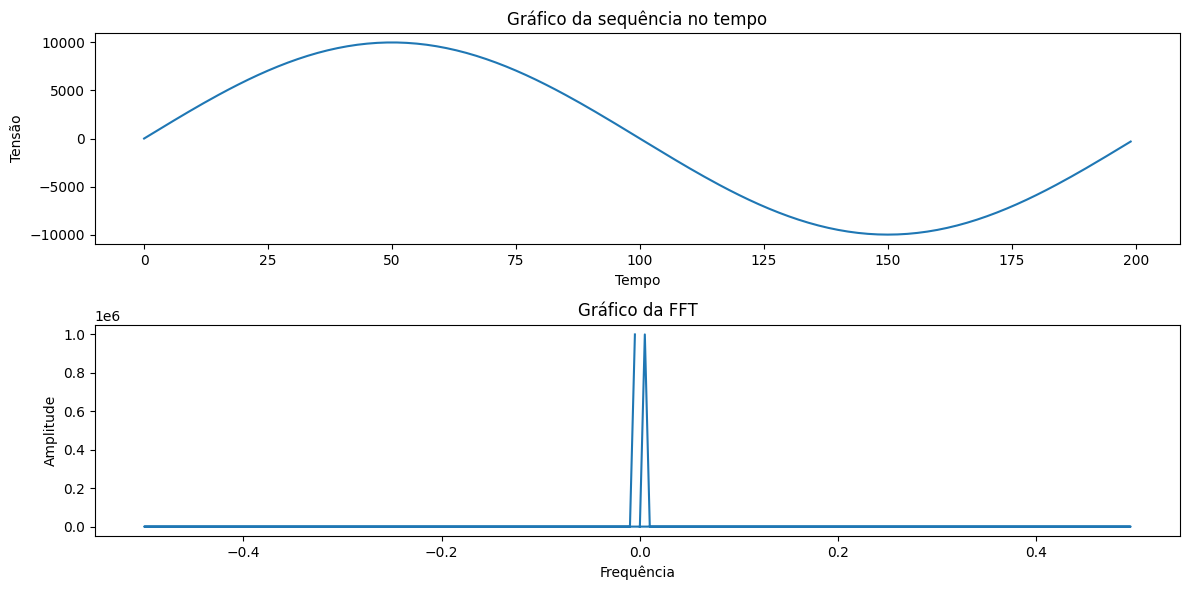

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import serial
import json

# Classe base para fonte de dados
class FonteDeDados:
    def __init__(self, config):
        self.config = config

    def ler_dados(self):
        pass

# Classe para leitura de dados de arquivo
class LeitorDeArquivo(FonteDeDados):
    def ler_dados(self):
        nome_arquivo = self.config.get("nome_arquivo")
        try:
            with open(nome_arquivo, 'rb') as arquivo:
                conteudo = arquivo.read()
            return conteudo
        except FileNotFoundError:
            print(f"Erro: O arquivo {nome_arquivo} não foi encontrado.")
            return None
        except Exception as e:
            print(f"Erro ao ler o arquivo: {e}")
            return None

# Classe para leitura de dados da porta serial
class LeitorSerial(FonteDeDados):
    def ler_dados(self):
        porta_serial = self.config.get("porta_serial")
        velocidade_baud = self.config.get("velocidade_baud")
        timeout = self.config.get("timeout")
        try:
            with serial.Serial(porta_serial, baudrate=velocidade_baud, timeout=timeout) as porta:
                # Descartar dados iniciais
                porta.reset_input_buffer()
                dados = porta.read_all()
            return dados
        except serial.SerialException as e:
            print(f"Erro na porta serial: {e}")
            return None
        except Exception as e:
            print(f"Erro ao ler da porta serial: {e}")
            return None

def calcular_fft_e_plotar(sequencia_tempo, sequencia_tensao, nome_arquivo_saida):
    # Calcular a FFT dos dados de tensão
    fft_resultado = fft(sequencia_tensao)

    # Calcular as frequências correspondentes à FFT
    n = len(sequencia_tempo)
    frequencias = fftfreq(n)

    # Criar os gráficos
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sequencia_tempo, sequencia_tensao)
    plt.title('Gráfico da sequência no tempo')
    plt.xlabel('Tempo')
    plt.ylabel('Tensão')

    plt.subplot(2, 1, 2)
    plt.plot(frequencias, np.abs(fft_resultado))
    plt.title('Gráfico da FFT')
    plt.xlabel('Frequência')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.savefig(nome_arquivo_saida)
    plt.show()

if __name__ == "__main__":
    # Carregar configurações do arquivo JSON
    with open("config.json", "r") as config_file:
        config = json.load(config_file)

    # Determinar o modo de leitura (serial ou arquivo)
    modo = config.get("modo")

    if modo == "serial":
        leitor = LeitorSerial(config)
    elif modo == "arquivo":
        leitor = LeitorDeArquivo(config)
    else:
        print("Modo de leitura não suportado.")
        leitor = None

    if leitor:
        dados = leitor.ler_dados()
        if dados:
            # Decodificar os dados, aplicar fatores escalares e separar em sequência de tempo e tensão
            dados_decodificados = np.frombuffer(dados, dtype=np.int16)
            fator_tempo = config.get("fator_tempo")
            fator_tensao = config.get("fator_tensao")
            sequencia_tempo = dados_decodificados[::2] * fator_tempo
            sequencia_tensao = dados_decodificados[1::2] * fator_tensao

            # Calcular FFT e plotar gráficos
            nome_arquivo_saida = "graficos.png"  # Substitua pelo nome desejado
            calcular_fft_e_plotar(sequencia_tempo, sequencia_tensao, nome_arquivo_saida)
        else:
            print("Não foi possível ler os dados.")
